# Lectura y análisis de propiedades (ICF)
Notebook con funciones para leer HDF5, extraer propiedades, generar animaciones, cortes, cálculo de modos radiales promediados en H y en posiciones z0, y evolución temporal de dichos modos.
Geometría cilíndrica: X = H (altura, µm), Y = R (radio, µm).

# Diccionario de propiedades

# Funciones: lectura, extracción y visualización

In [1]:
# ============================================================
# Lectura y análisis de propiedades (ICF)
# Geometría cilíndrica: Z (altura), R (radio)
# Código robusto para tiempos equiespaciados, no equiespaciados
# y simulaciones concatenadas
# ============================================================

import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

# ============================================================
# Diccionario de propiedades
# ============================================================

propiedades = {
    0: "lower x edge [m]",
    1: "upper x edge [m]",
    2: "lower y edge [m]",
    3: "upper y edge [m]",
    4: "cell volume [m3]",
    5: "material temperature [eV]",
    6: "rad intensity group 1 [W/m2]",
    7: "rad intensity group 2 [W/m2]",
    8: "rad intensity group 3 [W/m2]",
    9: "rad intensity group 4 [W/m2]",
    10: "rad intensity group 5 [W/m2]",
    11: "rad intensity group 6 [W/m2]",
    12: "rad intensity group 7 [W/m2]",
    13: "rad intensity group 8 [W/m2]",
    14: "integrated radiation intensity [W/m2]",
    15: "volumetric energy source [W/m3]",
    16: "radiation temperature [eV]",
    17: "rho*Cv [J/m3/K]",
    18: "dT_emission"
}

# ============================================================
# Extraer propiedad (ROBUSTO)
# ============================================================

def extraer_propiedad(ruta_hdf5, indice_propiedad):
    """
    Extrae una propiedad usando el tiempo físico real.
    Funciona con:
    - tiempos uniformes
    - tiempos no uniformes
    - simulaciones concatenadas
    """

    base = os.path.basename(ruta_hdf5)
    nombre = os.path.splitext(base)[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)
    os.makedirs(carpeta, exist_ok=True)

    tiempos = []
    frames = []

    with h5py.File(ruta_hdf5, "r") as f:
        for name, ds in f.items():
            if not name.startswith("box_fine"):
                continue
            if "time" not in ds.attrs:
                continue

            t = float(ds.attrs["time"][0])          # segundos
            prop = ds[..., indice_propiedad].T      # (Nz, Nr)

            tiempos.append(t)
            frames.append(prop)

    if len(frames) == 0:
        raise RuntimeError("No se encontraron datasets box_fine con atributo 'time'")

    tiempos = np.array(tiempos)
    frames = np.array(frames)

    # Ordenar por tiempo físico
    orden = np.argsort(tiempos)
    tiempos = tiempos[orden]
    frames = frames[orden]

    # Guardar
    ruta_prop = os.path.join(carpeta, f"prop_{indice_propiedad:02d}.npy")
    ruta_tiempos = os.path.join(carpeta, "tiempos.npy")

    np.save(ruta_prop, frames)
    np.save(ruta_tiempos, tiempos)

    print(f"✔ Guardado:\n  {ruta_prop}\n  {ruta_tiempos}")

    return ruta_prop

# ============================================================
# Leer tiempos físicos (desde .npy)
# ============================================================

def leer_tiempos(ruta_hdf5):
    base = os.path.basename(ruta_hdf5)
    nombre = os.path.splitext(base)[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    ruta_tiempos = os.path.join(carpeta, "tiempos.npy")
    if not os.path.exists(ruta_tiempos):
        raise FileNotFoundError("No existe tiempos.npy. Ejecuta extraer_propiedad.")

    return np.load(ruta_tiempos)  # segundos

# ============================================================
# Índices temporales por tiempos físicos (GENERAL)
# ============================================================

def indices_por_tiempos_ns(tiempos_s, tiempos_ns_obj):
    tiempos_ns = tiempos_s * 1e9
    idx = []
    for t in tiempos_ns_obj:
        i = np.argmin(np.abs(tiempos_ns - t))
        idx.append(i)
    return np.array(idx, dtype=int)

# ============================================================
# Visualizar varios tiempos físicos
# ============================================================

def ver_propiedad_por_tiempos(
    ruta_hdf5,
    indice_propiedad,
    tiempos_ns_objetivo,
    vmin=None,
    vmax=None
):
    base = os.path.basename(ruta_hdf5)
    nombre = os.path.splitext(base)[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    ruta_npy = os.path.join(carpeta, f"prop_{indice_propiedad:02d}.npy")
    if not os.path.exists(ruta_npy):
        raise FileNotFoundError("Ejecuta primero extraer_propiedad")

    data = np.load(ruta_npy)  # (Nt, Nz, Nr)
    tiempos_s = leer_tiempos(ruta_hdf5)

    idx = indices_por_tiempos_ns(tiempos_s, tiempos_ns_objetivo)
    frames = data[idx]

    if vmin is None or vmax is None:
        vmin, vmax = np.percentile(frames, [2, 98])

    n = len(idx)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), constrained_layout=True)

    if n == 1:
        axes = [axes]

    nombre_prop = propiedades.get(indice_propiedad, f"prop_{indice_propiedad:02d}")

    for ax, i, t in zip(axes, idx, tiempos_ns_objetivo):
        im = ax.imshow(
            data[i],
            origin="lower",
            cmap="inferno",
            vmin=vmin,
            vmax=vmax
        )
        ax.set_title(f"t = {t:.3f} ns")
        ax.set_xlabel("r [µm]")
        ax.set_ylabel("z [µm]")

    cbar = fig.colorbar(im, ax=axes, shrink=0.85)
    cbar.set_label(nombre_prop)

    fig.suptitle(nombre_prop, fontsize=14, weight="bold")
    plt.show()

# ============================================================
# Animación temporal
# ============================================================

def visualizar_propiedad(ruta_hdf5, indice_propiedad, fps=10, formato="mp4"):
    base = os.path.basename(ruta_hdf5)
    nombre = os.path.splitext(base)[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    ruta_npy = os.path.join(carpeta, f"prop_{indice_propiedad:02d}.npy")
    if not os.path.exists(ruta_npy):
        raise FileNotFoundError("Ejecuta primero extraer_propiedad")

    data = np.load(ruta_npy)
    tiempos_s = leer_tiempos(ruta_hdf5)
    tiempos_ns = tiempos_s * 1e9

    vmin, vmax = np.percentile(data, [2, 98])

    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(data[0], origin="lower", cmap="inferno", vmin=vmin, vmax=vmax)

    nombre_prop = propiedades.get(indice_propiedad, f"prop_{indice_propiedad:02d}")

    titulo = ax.text(
        0.5, 1.10, nombre_prop,
        transform=ax.transAxes,
        ha="center", va="bottom",
        fontsize=14, weight="bold"
    )

    texto_t = ax.text(
        0.5, 1.02, "",
        transform=ax.transAxes,
        ha="center", va="bottom"
    )

    ax.set_xlabel("r [µm]")
    ax.set_ylabel("z [µm]")
    plt.colorbar(im, ax=ax)

    def update(i):
        im.set_data(data[i])
        texto_t.set_text(f"t = {tiempos_ns[i]:.3f} ns")
        return im,

    anim = FuncAnimation(fig, update, frames=len(data), interval=1000/fps)

    salida = os.path.join(carpeta, f"prop_{indice_propiedad:02d}.{formato}")
    if formato == "gif":
        anim.save(salida, writer=PillowWriter(fps=fps))
    else:
        anim.save(salida, writer=FFMpegWriter(fps=fps))

    print("✔ Animación guardada:", salida)


# Celdas finales para ejecución rápida y demostración

SACAR PROPIEDADES DE UNA RUTA

✔ Guardado:
  C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HDrad\prop_14.npy
  C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HDrad\tiempos.npy
✔ Animación guardada: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HDrad\prop_14.mp4
✔ Guardado:
  C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HDrad\prop_16.npy
  C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HDrad\tiempos.npy
✔ Animación guardada: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HDrad\prop_16.mp4


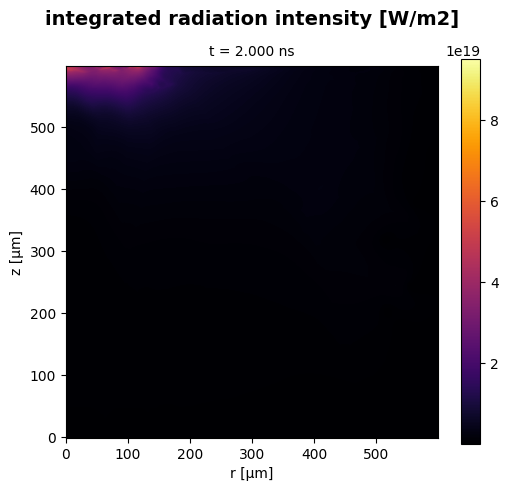

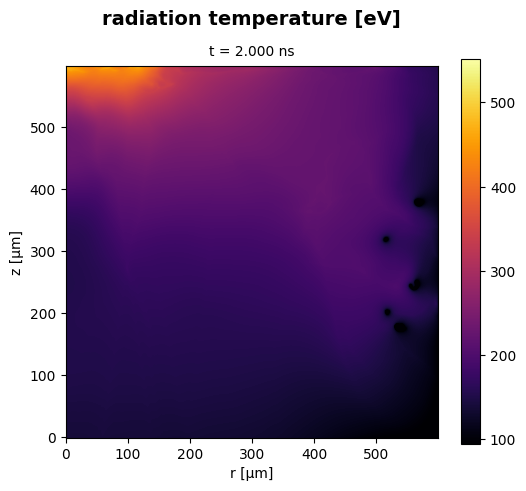

In [2]:
# Ajusta estas rutas/variables a tu entorno
ruta_hdf5 = r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HDrad.h5"
indice = [14,16]


for i in indice:

    ruta_npy = extraer_propiedad(ruta_hdf5, i)
    visualizar_propiedad(ruta_hdf5, i)


In [ ]:
# LoW DENSITY

indice_propiedad= 16

# Carpeta y HDF5
ruta_hdf5 = [r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HDrad.h5"]
t_ns = [ 0.02, 0.15, 0.4]

for r in ruta_hdf5:
    ver_propiedad_por_tiempos(
        r,
        indice_propiedad,
        tiempos_ns_objetivo= t_ns,
    )

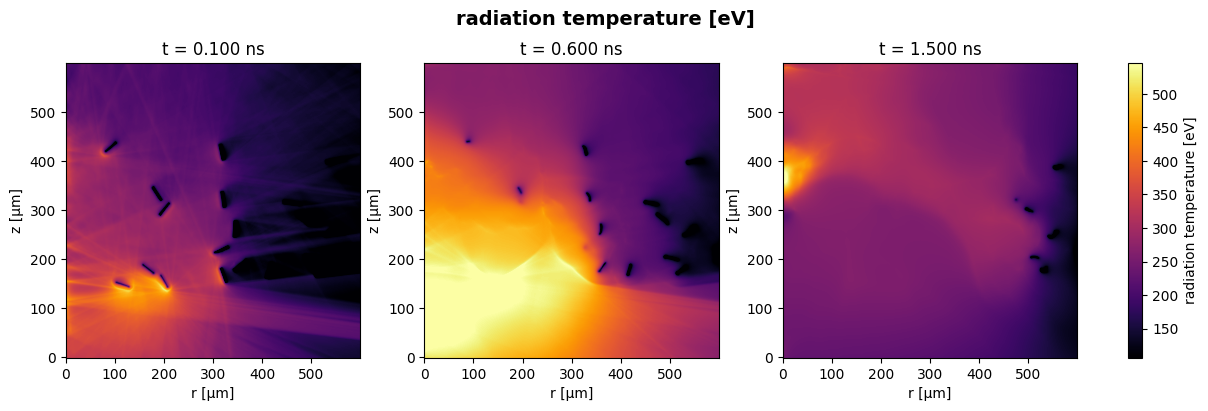

In [4]:
# HIGH DENSITY

indice_propiedad= 16

# Carpeta y HDF5
ruta_hdf5 = [r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_HDrad.h5"]
t_ns2 = [ 0.1, 0.6, 1.5]
t_ns = [ 0.2, 0.8, 1.8]

for r in ruta_hdf5:
    ver_propiedad_por_tiempos(
        r,
        indice_propiedad,
        tiempos_ns_objetivo= t_ns2,
    )